## ABOUT
__Author:__ Pat McCornack

__Date:__ 3/8/24

__Purpose__: As part of our efforts to develop a model that utilizes LANDFIRE data to classify FBFM40* values across the landscape we want to evaluate how LANDFIRE is currently mapping FBFM40 values. Specifically, we want to determine whether the FBFM40 "parent classes" (e.g. GS = Grass-Shrub) are primarily structural and therefore static between releases or if inter-group transitions occur.

The purpose of this is to evaluate whether we can include these FBFM40 "parent classes" as a predictor to model FBFM40 classes for the upcoming season. Inclusion of these parent classes has been shown to significantly enhance prediction accuracy, but we need to determine whether it makes sense to include them in the model.

*FBFM40 = 40 Scott and Burgan Fire Behavior Fuel Models


__Result__: While inter-group transitions are relatively rare compard to intra-group changes, they do occur and therefore the FBFM40 "parent classes cannot be considered static. 

----

In [2]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import fiona 

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Functions
-----

## Plot HeatMap

In [3]:
def plot_heatmap(pivotTable, figsize = (15,15)):
    """
    Plots a heatmap of the F40 mappings from LF22 to LF23.
    Input is a pivotTable with LF22 classes on the x-axis, LF23 classes on the y-axis, and class ['Count'/'LogCount'/'Percent'] as the values.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(pivotTable,
                    cmap="YlOrRd",
                    annot=True,
                    ax=ax)
    plt.show()

## Aggregate by F40 Parent Group

In [4]:
def agg_F40_groups(df):
    """
    Aggregates F40 classes into parent groups. 
    """
    # Create dictionary to aggregate F40 models into groups
    df = df[['Count', 'LF22', 'LF23']].copy()
    F40_groups = {
        range(91, 100):'NonBurnable',
        range(101,110):'Grass',
        range(121,125):'Grass-Shrub',
        range(141,150):'Shrub',
        range(161,166):'Timber-Understory',
        range(181,190):'Timber Litter',
        range(201,204):'Slash-Blowdown'
    }

    # Create columns to aggregate F40 models into groups
    df['LF22_GROUP'] = df['LF22'].apply(lambda x: next((v for k, v in F40_groups.items() if x in k), x))
    df['LF23_GROUP'] = df['LF23'].apply(lambda x: next((v for k, v in F40_groups.items() if x in k), x))

    # Aggregate count using tuples as keys
    df_agg = df.groupby(['LF22_GROUP', 'LF23_GROUP']).agg({"Count":"sum"}).reset_index()
    df_agg['Percent'] = (df_agg["Count"] / df_agg["Count"].sum() * 100).round(3)
    df_agg['LogCount'] = np.log(df_agg['Count'])

    return df_agg
        

## Pivot the data
Creates a pivot table of the data. The `values` parameter is used to specify how quantify the results. 'Count' returns the raw counts of classes, 'LogCount' returns the log-transformed count of the values - this is useful to create heatmaps that are more easily interpretable at a glance, 'Percent' returns the proportion of the total count that each combination represents. 

In [5]:
def pivot_data(df, values='Count', agg=False):
    """
    Returns pivot table with LF22 on x-axis, LF23 on y-axis, and ['Count'/'LogCount'/'Percent'] as value.
    agg=True specifies to use labels corresponding to groups. 
    """

    if agg == False:
        df_pivoted = df.pivot(columns='LF22', index='LF23', values=values)
    else:
        df_pivoted = df.pivot(columns='LF22_GROUP', index='LF23_GROUP', values=values)
    df_pivoted = df_pivoted.fillna(0)
    return df_pivoted

# Assessing LF22/23 F40 Class Mappings - Full F40 Dataset
How static are F40 classes between years?
This is NOT filtered by disturbance. 

-----

In [6]:
gdb_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\data\F40_data_working.gdb"
gdb_layer = r"VAT_F40_22_F40_23_combine"

F40_df = gpd.read_file(gdb_path, layer=gdb_layer)
F40_df = F40_df.rename(columns={"LC22_F40_220_bpa":"LF22", "LC22_F40_230_bpa":"LF23"})
F40_df.head()

,Value,Count,LF22,LF23,geometry
0,1,179517683.0,-9999,-9999,None
1,2,47590601.0,98,98,None
2,3,174834582.0,102,102,None
3,4,61838137.0,162,162,None
4,5,53504903.0,99,99,None


## Full F40 Dataset from BPA Service Territory - Groupwise Comparison
First let's look at how the groups (e.g. GR, GS) map between years for the unfiltered F40 data. 

In [7]:
# Aggregate data by F40 Group
df_agg = agg_F40_groups(F40_df)
df_agg.head()

,LF22_GROUP,LF23_GROUP,Count,Percent,LogCount
0,-9999,-9999,179517683.0,11.252,19.005784
1,Grass,Grass,204113198.0,12.794,19.134185
2,Grass,Grass-Shrub,4516156.0,0.283,15.323172
3,Grass,NonBurnable,14574248.0,0.914,16.494767
4,Grass,Shrub,1188398.0,0.074,13.988117


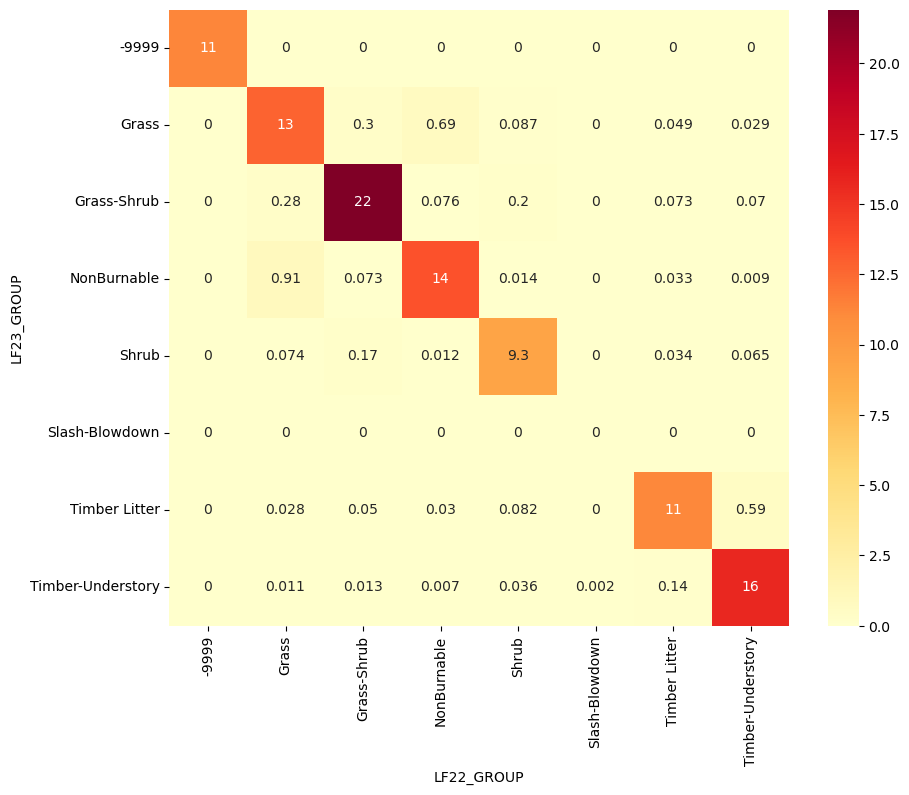

In [8]:
# Pivot df for heatmap 
df_pivoted = pivot_data(df_agg, values='Percent', agg=True)

# Plot heatmap
plot_heatmap(df_pivoted, figsize=(10,8))

In [9]:
# Look at raw data
pivot_data(df_agg, values='Percent', agg=True)  

LF22_GROUP,-9999,Grass,Grass-Shrub,NonBurnable,Shrub,Slash-Blowdown,Timber Litter,Timber-Understory
LF23_GROUP,,,,,,,,
-9999,11.252,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Grass,0.000,12.794,0.300,0.689,0.087,0.000,0.049,0.029
Grass-Shrub,0.000,0.283,21.913,0.076,0.204,0.000,0.073,0.070
NonBurnable,0.000,0.914,0.073,13.577,0.014,0.000,0.033,0.009
Shrub,0.000,0.074,0.175,0.012,9.282,0.000,0.034,0.065
Slash-Blowdown,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Timber Litter,0.000,0.028,0.050,0.030,0.082,0.000,11.203,0.587
Timber-Understory,0.000,0.011,0.013,0.007,0.036,0.002,0.138,15.729


## Full F40 Dataset from BPA Service Territory - Classwise Comparison

In [10]:
# Create features
df = F40_df[['LF22', 'LF23', 'Count']]
df['LogCount'] = np.log(df['Count'])
df['Percent'] = (df["Count"] / df["Count"].sum() * 100).round(3)

# Pivot data
df_pivoted = pivot_data(df, values='Percent')

# Plot Heatmap
#plot_heatmap(df_pivoted, figsize=(20,18))

C:\Users\mcco573\AppData\Local\Temp\ipykernel_19520\3251067822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LogCount'] = np.log(df['Count'])


# Effects of Disturbance on F40 Classes and Group
How static are F40 classes between years in areas that were disturbed?

-----

In [11]:
# Load Data
gdb_path = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\F40 Random Forest Model\data\F40_data_working.gdb"
gdb_layer = r"VAT_F40_22_F40_23_FDst_combine"

F40_df = gpd.read_file(gdb_path, layer=gdb_layer)
F40_df = F40_df.rename(columns={"LC22_F40_220_bpa":"LF22", "LC22_F40_230_bpa":"LF23", "LC22_FDst_230_bpa":"FDst"})


## All Disturbance Types - Groupwise Comparison
Look at F40 Group transitions of cells affected by any disturbance type.

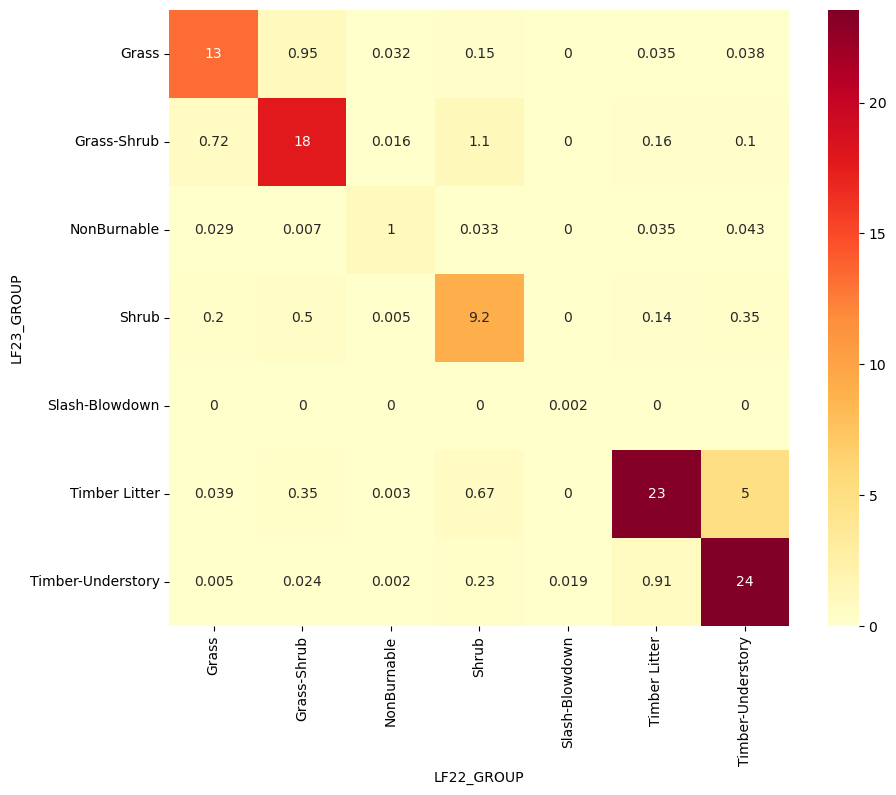

In [12]:
# Filter out non-disturbed and NA data
dist_F40 = F40_df.loc[~F40_df['FDst'].isin([-1111, -9999, 0])]

# Aggregate the data
dist_F40_agg = agg_F40_groups(dist_F40)

# Pivot the data
dist_F40_agg_pivot = pivot_data(dist_F40_agg, agg=True, values='Percent')

# Plot the data
plot_heatmap(dist_F40_agg_pivot, figsize=(10,8))

In [13]:
# Print counts
pivot_data(dist_F40_agg, values='Count', agg=True)

LF22_GROUP,Grass,Grass-Shrub,NonBurnable,Shrub,Slash-Blowdown,Timber Litter,Timber-Understory
LF23_GROUP,,,,,,,
Grass,23234140.0,1661809.0,56484.0,256613.0,60.0,61696.0,67024.0
Grass-Shrub,1254353.0,30939884.0,27547.0,1952347.0,381.0,276655.0,174984.0
NonBurnable,51376.0,12597.0,1800363.0,57597.0,25.0,60345.0,74744.0
Shrub,351795.0,876378.0,8199.0,16026371.0,44.0,248212.0,609575.0
Slash-Blowdown,0.0,68.0,2.0,4.0,4200.0,16.0,53.0
Timber Litter,68633.0,614661.0,5074.0,1175596.0,664.0,40786104.0,8816049.0
Timber-Understory,8938.0,42168.0,3392.0,393631.0,33020.0,1591612.0,41185406.0


## All disturbance types with D_Time = One Year
Look at group transitions for cells where disturbance occurred within the last year - therefore no changes are due to succession without disturbance. 

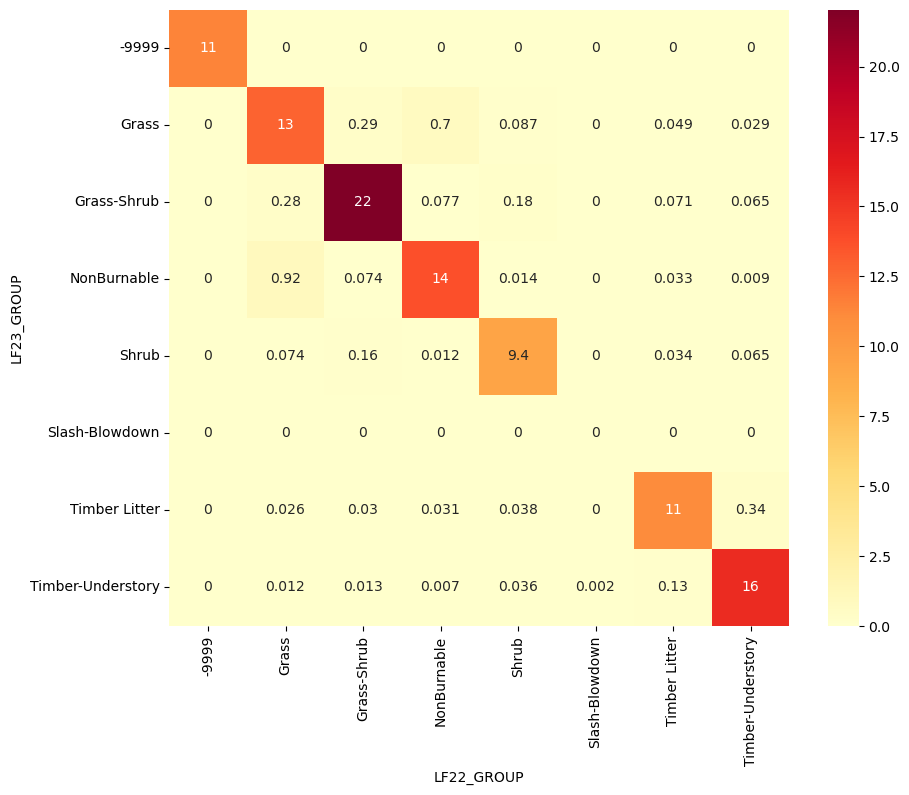

In [14]:
# Filter cells where disturbance occurred in last year
dist_F40 = F40_df.loc[~F40_df['FDst'].isin([111, 211, 311, 411, 511, 611, 711])]

# Aggregate the data
dist_F40_agg = agg_F40_groups(dist_F40)

# Pivot the data
dist_F40_agg_pivot = pivot_data(dist_F40_agg, agg=True, values='Percent')

# Plot the data
plot_heatmap(dist_F40_agg_pivot, figsize=(10,8))

In [15]:
# Print counts
pivot_data(dist_F40_agg, values='Count', agg=True)

LF22_GROUP,-9999,Grass,Grass-Shrub,NonBurnable,Shrub,Slash-Blowdown,Timber Litter,Timber-Understory
LF23_GROUP,,,,,,,,
-9999,179517683.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grass,0.0,203328087.0,4663267.0,10995312.0,1377413.0,178.0,774125.0,454128.0
Grass-Shrub,0.0,4459917.0,347940945.0,1217462.0,2877166.0,310.0,1116787.0,1029501.0
NonBurnable,0.0,14572949.0,1169839.0,216362560.0,226159.0,58.0,515418.0,136839.0
Shrub,0.0,1163438.0,2585714.0,195696.0,147708619.0,69.0,536196.0,1028396.0
Slash-Blowdown,0.0,1.0,68.0,2.0,4.0,5455.0,20.0,50.0
Timber Litter,0.0,416278.0,470223.0,485104.0,602075.0,607.0,175009089.0,5345636.0
Timber-Understory,0.0,181842.0,199223.0,115383.0,562672.0,33101.0,2105470.0,247240584.0


## No Disturbance
Look at group transitions without disturbances to provide a baseline

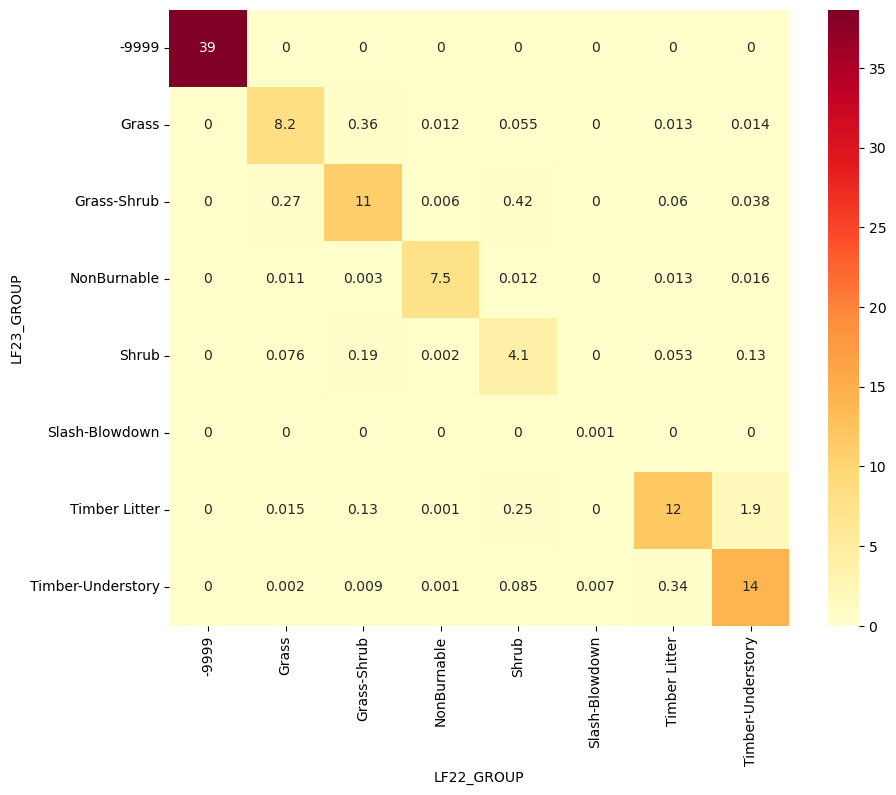

In [16]:
# Filter cells where disturbance occurred in last year
dist_F40 = F40_df.loc[~F40_df['FDst'].isin([0])]

# Aggregate the data
dist_F40_agg = agg_F40_groups(dist_F40)

# Pivot the data
dist_F40_agg_pivot = pivot_data(dist_F40_agg, agg=True, values='Percent')

# Plot the data
plot_heatmap(dist_F40_agg_pivot, figsize=(10,8))

In [17]:
# Print counts
pivot_data(dist_F40_agg, values='Count', agg=True)

LF22_GROUP,-9999,Grass,Grass-Shrub,NonBurnable,Shrub,Slash-Blowdown,Timber Litter,Timber-Understory
LF23_GROUP,,,,,,,,
-9999,179517683.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grass,0.0,38258597.0,1661809.0,56484.0,256613.0,60.0,61696.0,67024.0
Grass-Shrub,0.0,1254353.0,51190858.0,27547.0,1952347.0,381.0,276655.0,174984.0
NonBurnable,0.0,51376.0,12597.0,34717104.0,57597.0,25.0,60345.0,74744.0
Shrub,0.0,351795.0,876378.0,8199.0,18999629.0,44.0,248212.0,609575.0
Slash-Blowdown,0.0,0.0,68.0,2.0,4.0,4200.0,16.0,53.0
Timber Litter,0.0,68633.0,614661.0,5074.0,1175596.0,664.0,55338460.0,8816049.0
Timber-Understory,0.0,8938.0,42168.0,3392.0,393631.0,33020.0,1591612.0,65571748.0
